## **MobileNet CNN Model**

### **1. Import the necessary libraries**


In [8]:
# Import necessary libraries
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Check TensorFlow version
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.10.1


### **2. Run the following codes with CUDA GPU enabled**


In [9]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


### **3. Load and Preprocess Data**


In [10]:
# Set paths to your dataset
train_dir = "./DATASETS/resized_dataset_128/train"
val_dir = "./DATASETS/resized_dataset_128/val"

# Define image size and batch size
img_size = (128, 128)
batch_size = 12

# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)

### **4. Building MobileNet Model**


In [11]:
def create_mobilenet_model(learning_rate=0.001, dropout_rate=0.0, dense_units=128):
    # Load pre-trained InceptionV4 model without top layers
    base_model = MobileNet(
        weights="imagenet", include_top=False, input_shape=(128, 128, 3)
    )

    # Freeze initial layers to keep pre-trained weights unchanged
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for MRI classification task
    x = GlobalAveragePooling2D()(base_model.output)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    x = Dense(dense_units, activation="relu")(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation="softmax")(x)

    # Create final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with specified learning rate
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model

### **5. Train the Model**


In [6]:
# Define parameter grid
param_grid = {
    "learning_rate": [0.01, 0.001, 0.0001],
    "dropout_rate": [0.0, 0.2, 0.5],
    "dense_units": [128, 256, 512],
}

# # Define parameter grid
# param_grid = {
#     "learning_rate": [0.001],
#     "batch_size": [12],
#     "dropout_rate": [0.5],
# }

# Create combinations of parameters
grid = list(ParameterGrid(param_grid))

# Initialize variables to keep track of the best model
best_params = None
best_model = None
best_history = None
best_accuracy = 0.0
best_loss = 0.0

# Iterate over parameter combinations
for params in grid:
    # Print current parameters
    print(f"Parameters: {params}")

    # Create model with current parameters
    model = create_mobilenet_model(
        learning_rate=params["learning_rate"], dropout_rate=params["dropout_rate"]
    )

    # Set up data generators
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
    )

    valid_generator = valid_datagen.flow_from_directory(
        val_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical",
        shuffle=False,
    )

    # # Define callbacks
    early_stopping = EarlyStopping(
        monitor="val_loss", patience=8, restore_best_weights=True
    )

    history = model.fit(
        train_generator,
        epochs=25,
        validation_data=valid_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        validation_steps=valid_generator.samples // valid_generator.batch_size,
        # callbacks=[early_stopping],
    )

    # Retrieve validation accuracy from history
    val_accuracy = max(history.history["val_accuracy"])
    val_loss = min(history.history["val_loss"])

    # Check if current model is the best one based on validation accuracy
    if val_accuracy > best_accuracy:
        print(f"New best model found: Validation Accuracy {val_accuracy}")
        best_accuracy = val_accuracy
        best_params = params
        best_history = history.history
        best_model = model
        best_loss = val_loss

# Save the best model
best_model.save("mobilenet_128_model.h5")

# Print and save best results
print(f"Best Parameters: {best_params}")
print(f"Val Accuracy: {best_accuracy}")
print(f"Val Loss: {best_loss}")

Parameters: {'dense_units': 128, 'dropout_rate': 0.0, 'learning_rate': 0.01}
Found 336 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
Epoch 1/25
28/28 [==============================] - 3s 59ms/step - loss: 2.6323 - accuracy: 0.5179 - val_loss: 0.8664 - val_accuracy: 0.6562
Epoch 2/25
28/28 [==============================] - 1s 39ms/step - loss: 0.6280 - accuracy: 0.7440 - val_loss: 0.4954 - val_accuracy: 0.7812
Epoch 3/25
28/28 [==============================] - 1s 38ms/step - loss: 0.4555 - accuracy: 0.8482 - val_loss: 0.6132 - val_accuracy: 0.7917
Epoch 4/25
 9/28 [========>.....................] - ETA: 0s - loss: 0.4470 - accuracy: 0.8241

### **6. Evaluate and Visualize Results**


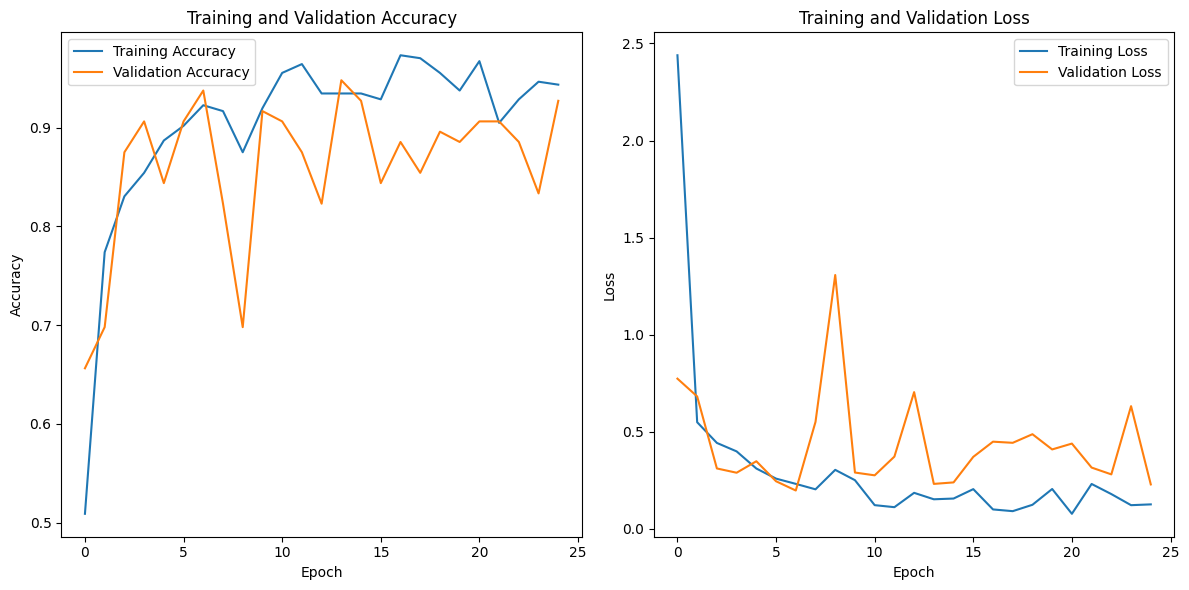

4/4 [==============================] - 0s 19ms/step - loss: 0.2960 - accuracy: 0.8750
Test Accuracy: 0.8750
Test Loss: 0.2960


In [ ]:
# Plot best model training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(best_history["accuracy"], label="Training Accuracy")
plt.plot(best_history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.xticks([0, 5, 10, 15, 20, 25])
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history["loss"], label="Training Loss")
plt.plot(best_history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.xticks([0, 5, 10, 15, 20, 25])
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

test_loss, test_accuracy = best_model.evaluate(valid_generator, verbose=1)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

### **6. Evaluation on validation set**


Found 144 images belonging to 4 classes.
12/12 [==============================] - 1s 11ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.86      0.89        36
  meningioma       0.82      0.92      0.87        36
   pituitary       0.97      0.97      0.97        36
     notumor       0.97      0.92      0.94        36

    accuracy                           0.92       144
   macro avg       0.92      0.92      0.92       144
weighted avg       0.92      0.92      0.92       144



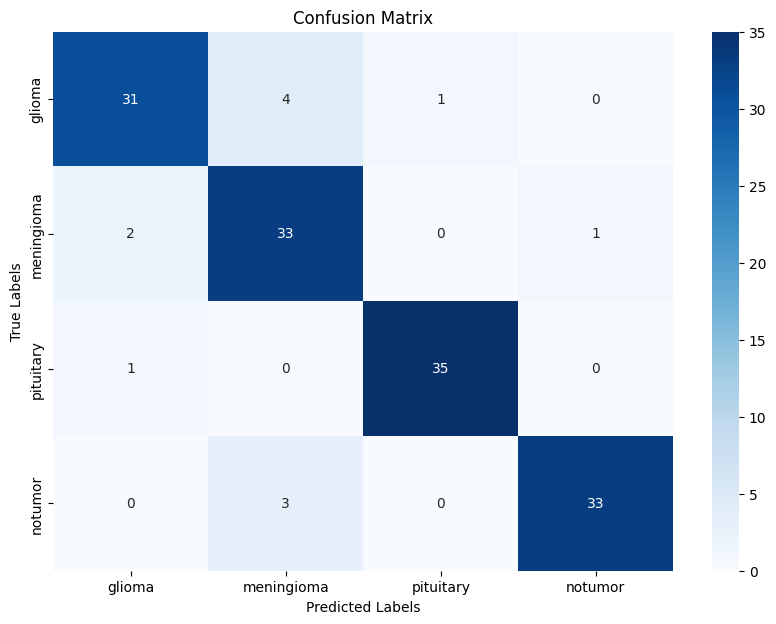

In [12]:
# Load the best saved model
mode_name = "mobilenet_128_model.h5"
model = load_model(mode_name)

# Set up data generators
valid_generator = valid_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

# Recompile the model with the correct metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),  # or any other optimizer you want to use
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Predict the labels for the test set
categories = ["glioma", "meningioma", "pituitary", "notumor"]
y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = valid_generator.classes

# Compute the classification report
report = classification_report(y_true, y_pred_classes, target_names=categories)
print("Classification Report:\n")
print(report)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=categories,
    yticklabels=categories,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()